# Ensemble Kalman Filters - Extended version
## Our motivation with this program

Our problem is the following: we have a grey box model which is a model that we partially know the intrinsic processes. This model has got dynamical variables $X$ and static parameters $\theta$. Usually, methods such as data-assimilation methods aim at estimating the latent state of a system by combining a model with real observations. These unknown static parameters need to be estimated from the data.

For the sake of simplicity, in this exemple we will use the 3-variable, chaotic Lorenz 63 system (https://en.wikipedia.org/wiki/Lorenz_system). This dynamical model is often used to test data assimilation methods, because it displays a chaotic behavior with very low dimensionality. 

The Lorenz equations can be written in the following form :

\begin{equation} 
\begin{aligned} \frac{dx}{dt} & = \sigma(y-x) \\ \frac{dy}{dt} & = \rho x - y - xz \\ \frac{dz}{dt} & = -\beta z + xy \end{aligned} 
\end{equation} 

This system is a non-linear differential system of order 1 with dynamical variables $x$, $y$ and $z$ and  static parameters, $\sigma$, $\beta$ and $\rho$. 

In this exemple, we don't use a grey box model but a white box model. A white-box model (also called glass box or clear box) is a system where all necessary information is available. My modjo when I am trying to explain a concept is: "Why complicate things when they can be simple?".

Data-assimilation has found numerous of applications in various fields such as oceanography, geosciences, meteorology or finance. The rise and the generalization of these methods have occurred in the middle of the 20-th century with the works of Kalman

In the case of sequential data assimilation, it is common to consider a state-space model for the white/grey/black model. The state-space models, also known as Hidden Markov Models (HMM), are a very popular class of time series models.


A state-space model is defined sequentially for $t=1:T$ by:
\begin{equation}
\left\{
\begin{array}{r c l}
\mathbf{X}_{t} &=& \mathcal{M}(\mathbf{X}_{t-1},{\mathbf{\theta}_1})+\nu_{t}\\
\mathbf{Y}_{t} &=& \mathcal{H}(\mathbf{X}_{t},{\mathbf{\theta}_2})+\epsilon_t
\end{array}
\right.
\end{equation}

Where, the variables $\nu_{t}$ and $\epsilon_t$ are independent white noise sequences with coriance matrices respectively Q and R.

The process $\mathbf{X}_{t}$ is called the hidden state and takes values in $\mathbb{R}^{n_x}$

The function $\mathcal{M}$ describes the evolution of the hidden state $\mathbf{X}_{t-1}$ to the next one $\mathbf{X}_{t}$. $\mathcal{H}$ describes the transformation between the state and the observations $\mathbf{Y}_{t}$. 

\begin{equation}
\mathbf{\theta}=\begin{bmatrix}
\mathbf{\theta}_1\\
\mathbf{\theta}_2\\  
\end{bmatrix}
\end{equation}


$\mathbf{\theta} \in \mathbb{O}$, where $\mathbb{O} \in \mathbb{R}^\theta$, is the vector of the parameters of the model.

The black/white/grey model can be considered such as the function composition of $\mathcal{M}$ and $\mathcal{H}$ such as $\mathcal{H} \circ \mathcal{M}$.



In [1]:
#Numpy is your best friend
import numpy as np 
from numpy.random import RandomState
from numpy.linalg import cholesky
#Tools for plotting
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.colors import cnames
import matplotlib.animation as animation
from algos.utils import sqrt_svd
import models.Lorenz_wrapper as wrap #Wrapper to choose
from algos.utils import  RMSE, gen_truth, gen_obs #Useful tools for data studies
from algos.EnKF import EnKF #Algorithme of Ensemble Kalman Filter
prng = RandomState(6) # random number generator

### The Ensemble Kalman Filter (EnKF)
It works in two phases, forecast and analysis. In the forecast phase, the ensemble is propagated by the nonlinear dynamics. This ensemble of samples allows computing an approximation of the error covariance matrix. The analysis step is computed in Kalman's fashion: the analysis equations are applied to each member of the ensemble.

In [2]:
# Background values
x_b = 3
y_b = -3
z_b = 21

# Simulation Parameters 
deltat = 1/100.
max_time=10.0
res = int(max_time / deltat)

dx = 3 # dimension of the state
dy = 3 # dimension of the observations

Ne=150 #Number of Elements for EnKF

sigma_true=10.0;rho_true=29.0;beta_true=8./3# physical true parameters

#Dynamical True Model Python version
fmdl_true=wrap.M(deltat=deltat)
m_true = lambda x: fmdl_true.Lorenz(x) 
#Dynamical Perturbated Model Python version
fmdl_perturb=wrap.M(deltat=deltat,sigma=sigma_true,rho=rho_true,beta=beta_true)
m_perturb = lambda x: fmdl_perturb.Lorenz(x)

We consider the case where all variables ($x$, but also $y$ and $z$) are observed at all times. Thus, the Observation Function called $\mathcal{H}$ is in our case in the following form:
$$
\begin{vmatrix}
1&0&0\\
0&1&0\\
0&0&1\\
\end{vmatrix}
$$


In [3]:
#Observation Function
H = np.eye(3)
#H = H[(0,2),:] # first and third variables are observed
h = lambda x: H.dot(x)  # observation model

The dynamical system described can be written as:
\begin{equation}
\left\{
\begin{array}{r c l}
\mathbf{U}_{t+1} &=& \mathcal{M}(\mathbf{U}_{t})+\nu_{t}\\
\mathbf{Y}_{t} &=& \mathcal{H}(\mathbf{U}_{t})+\epsilon_t
\end{array}
\right.
\end{equation}
Where,
\begin{equation}
\nu_{t}=\begin{bmatrix}
   e_{\mathbf{x}}\\
   e_{\mathbf{\theta}}\\
\end{bmatrix}_t
\end{equation}

$\nu_{t}$~$\mathcal{N}(0,Q)$ and $\epsilon_t$~$\mathcal{N}(0,R)$

For the sake of simplification, error covariances are considered to be diagonal. Consequently, we assume that $Q=\sigma_Q^2I$, $B=\sigma_B^2I$ and $R=\sigma_R^2I$, where $I$ is the identity matrix.

In [4]:
# Setting covariances for true
sig2_Q =0.0; sig2_R =0.0 # parameters
Q_true = np.eye(dx) *sig2_Q # model covariance
R_true = np.eye(dy) *sig2_R # observation covariance
#R_true = R_true[(0,2),:]

# Setting covariances for perturbated model
sig2_Q_perturb =0.0; sig2_R_perturb =0.5 # parameters
sig2_B_perturb=np.array([2,1.5,0.1]) # parameters
Q_perturb = np.eye(dx) *sig2_Q_perturb # model covariance
R_perturb = np.eye(dy) *sig2_R_perturb # observation covariance
#R_perturb = R_perturb[(0,2),:]
print(R_perturb)
# Prior state
x0_true = np.r_[1.5, -1.5, 21]
x0_perturb = np.r_[x_b, y_b, z_b]
B = np.eye(dx) *sig2_B_perturb

[[0.5 0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  0.5]]


For the experiment we simulate $T=400$ observations of the Lorenz-63  with model time step $\Delta t=0.1$. In order to evaluate the Data-Assimilation, we will perform twin experiments. The aim of these twin experiments is to define a trajectory obtained from the model considered as a reference. As in the case of a real Data-assimilation, the goal will be to estimate as accurately as possible this reference.

In [5]:
# Latent State Generation
X_true = gen_truth(m_true, x0_true, res, Q_true, prng) #Latent State Generation from true model
X_perturb = gen_truth(m_perturb, x0_perturb, res, Q_perturb, prng) #Latent State Generation from perturbated model
# Observations Generation²
Y_true = gen_obs(h, X_true, R_true, prng) #Observation from true model
sqR = sqrt_svd(R_perturb)
Y_perturb = Y_true + sqR.dot(prng.normal(size=(Y_true.shape[0], Y_true.shape[1])))

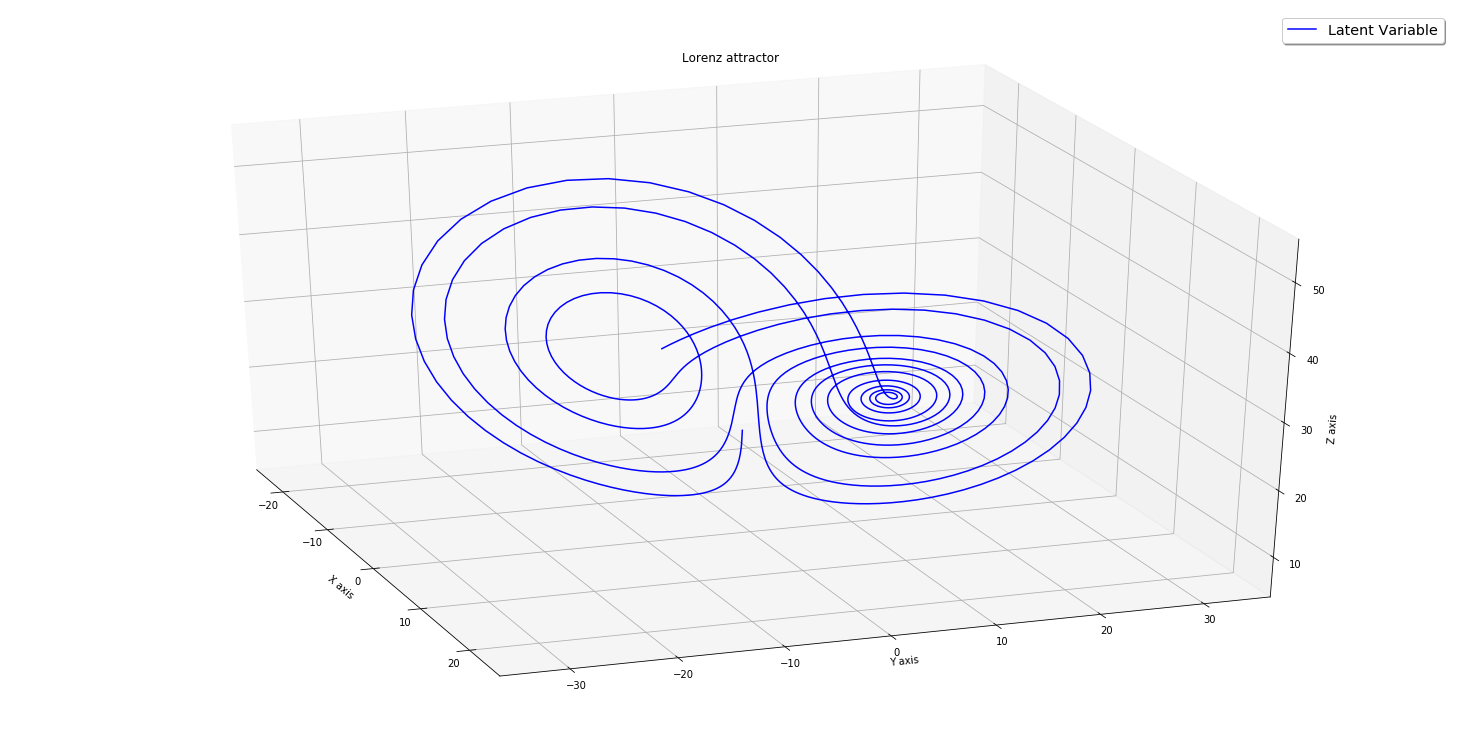

In [6]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
# Prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('Lorenz attractor')
# Second Plot
lines_ref = ax.plot(Y_true[0,:], Y_true[1,:], Y_true[2,:], 'b-',label='Latent Variable')
ax.view_init(30, -20)
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig('Lorenz_model.png')
plt.show() 

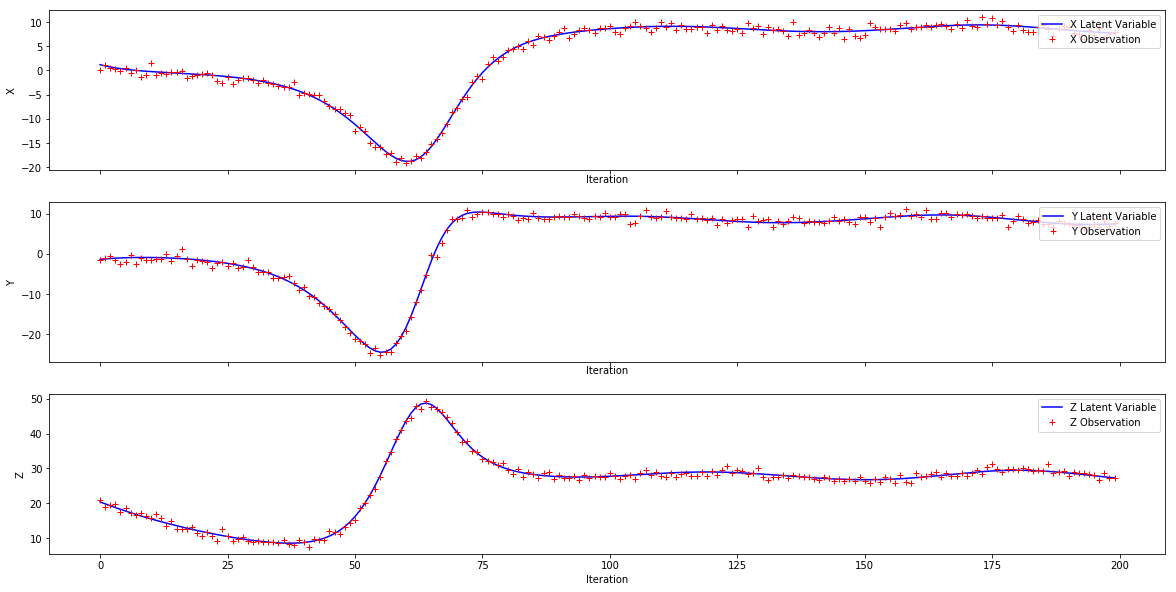

In [7]:
# First Plot
f, axarr = plt.subplots(3, sharex=True,figsize=(20,10))
axarr[0].set_xlabel('Iteration')
axarr[0].set_ylabel('X')
axarr[0].plot(Y_true[0,:int(Y_true.shape[1]/5)], 'b-', label='X Latent Variable')
axarr[0].plot(Y_perturb[0,:int(Y_true.shape[1]/5)],'r+', label='X Observation')
axarr[0].legend(loc="upper right")
axarr[1].plot(Y_true[1,:int(Y_true.shape[1]/5)], 'b-', label='Y Latent Variable')
axarr[1].plot(Y_perturb[1,:int(Y_true.shape[1]/5)],'r+', label='Y Observation')
axarr[1].legend(loc="upper right")
axarr[1].set_xlabel('Iteration')
axarr[1].set_ylabel('Y')
axarr[2].plot(Y_true[2,:int(Y_true.shape[1]/5)], 'b-', label='Z Latent Variable')
axarr[2].plot(Y_perturb[2,:int(Y_true.shape[1]/5)],'r+', label='Z Observation')
axarr[2].legend(loc="upper right")    
axarr[2].set_xlabel('Iteration')
axarr[2].set_ylabel('Z')
plt.savefig('Comparison_Lorenz_model.png')

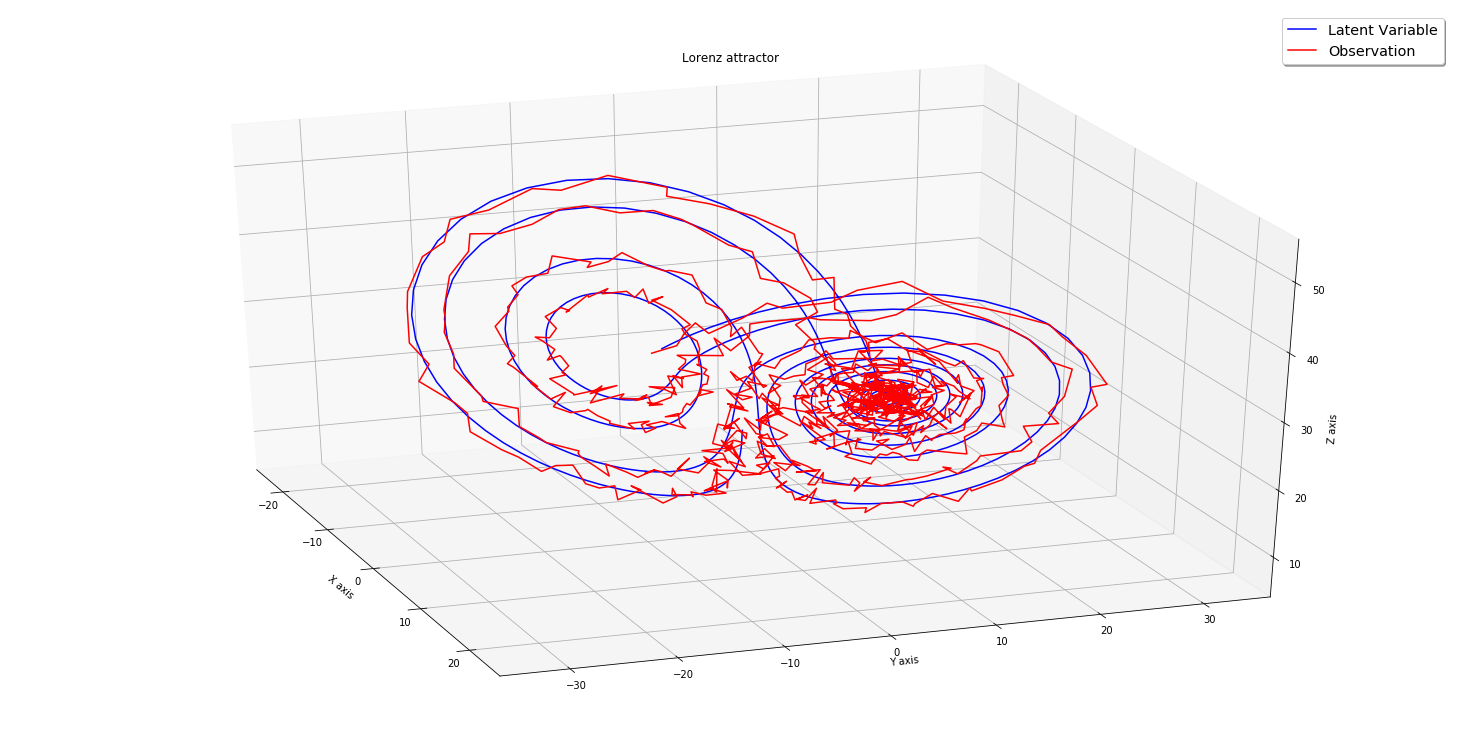

In [8]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
# Prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('Lorenz attractor')
# Second Plot
lines_ref = ax.plot(Y_true[0,:], Y_true[1,:], Y_true[2,:], 'b-',label='Latent Variable')
lines_fore = ax.plot(Y_perturb[0,:], Y_perturb[1,:], Y_perturb[2,:], 'r-',label='Observation')
ax.view_init(30, -20)
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig('Observation_Lorenz_model.png')
plt.show() 

The state vector for each ensemble member $j$ at time step $t$ is denoted by:
\begin{equation}
\mathbf{U}_{t,j}=\begin{bmatrix}
   x\\
   y\\
   z\\
   \sigma\\
   \rho\\
   \beta\\   
\end{bmatrix}_{t,j}
\label{Equation8}
\end{equation}

In [9]:
### Data-Asssimilation
#Ensemble Kalman Filter
Xa_enkf, Xf_enkf = EnKF(dx, res, 3, x0_perturb, B, Q_perturb, R_perturb, Ne,  m_perturb, H, Y_perturb, prng)
#Mean of the Ensemble Kalman Filter Results
Xa_enkf_mean=np.mean(Xa_enkf, axis=1)
Xf_enkf_mean=np.mean(Xf_enkf, axis=1)

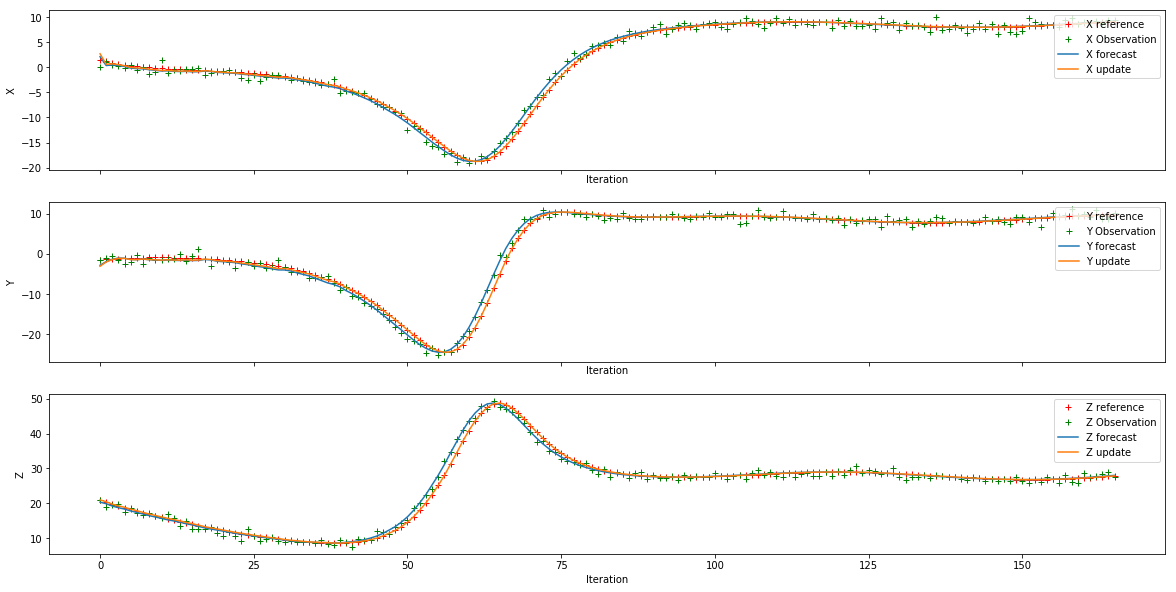

In [10]:
# First Plot
f, axarr = plt.subplots(3, sharex=True,figsize=(20,10))
axarr[0].plot(X_true[0,:int(Y_true.shape[1]/6)], 'r+', label='X reference')
axarr[0].plot(Y_perturb[0,:int(Y_true.shape[1]/6)],'g+', label='X Observation')
axarr[0].plot(Xf_enkf_mean[0,:int(Y_true.shape[1]/6)], label='X forecast')
axarr[0].plot(Xa_enkf_mean[0,:int(Y_true.shape[1]/6)], label='X update')
axarr[0].legend(loc="upper right")
axarr[0].set_xlabel('Iteration')
axarr[0].set_ylabel('X')
axarr[1].plot(X_true[1,:int(Y_true.shape[1]/6)], 'r+', label='Y reference')
axarr[1].plot(Y_perturb[1,:int(Y_true.shape[1]/6)],'g+', label='Y Observation')
axarr[1].plot(Xf_enkf_mean[1,:int(Y_true.shape[1]/6)], label='Y forecast')
axarr[1].plot(Xa_enkf_mean[1,:int(Y_true.shape[1]/6)], label='Y update')
axarr[1].legend(loc="upper right")
axarr[1].set_xlabel('Iteration')
axarr[1].set_ylabel('Y')
axarr[2].plot(X_true[2,:int(Y_true.shape[1]/6)], 'r+', label='Z reference')
axarr[2].plot(Y_perturb[2,:int(Y_true.shape[1]/6)],'g+', label='Z Observation')
axarr[2].plot(Xf_enkf_mean[2,:int(Y_true.shape[1]/6)], label='Z forecast')
axarr[2].plot(Xa_enkf_mean[2,:int(Y_true.shape[1]/6)], label='Z update')
axarr[2].legend(loc="upper right")
axarr[2].set_xlabel('Iteration')
axarr[2].set_ylabel('Z')
plt.savefig('Comparison_ENKF_Lorenz_model.png')

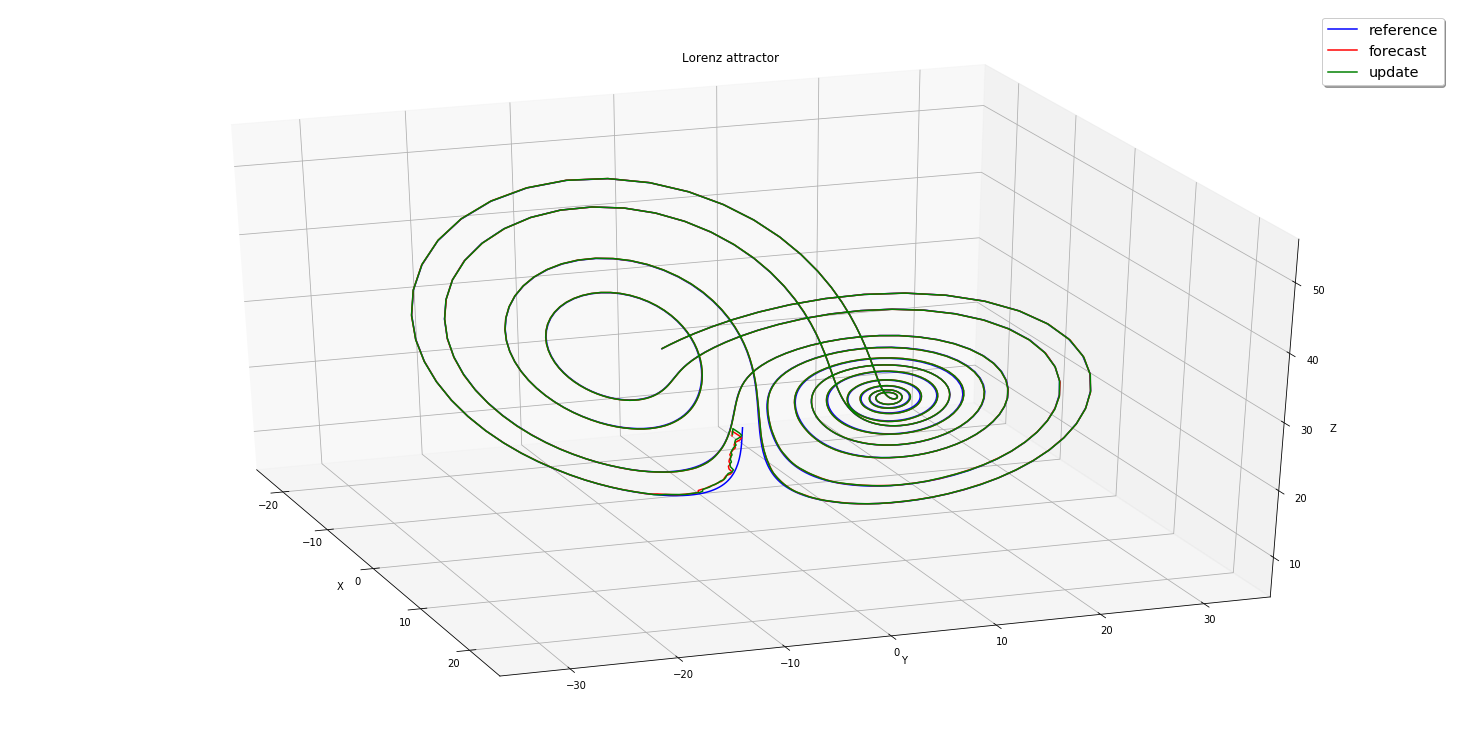

In [11]:
fig = plt.figure(figsize=(20,10))
# Prepare the axes limits
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('Lorenz attractor')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# Second Plot
lines_ref = ax.plot(X_true[0,:], X_true[1,:], X_true[2,:], 'b-',label='reference')
lines_fore = ax.plot(Xf_enkf_mean[0,:], Xf_enkf_mean[1,:], Xf_enkf_mean[2,:], 'r-',label='forecast')
lines_upda = ax.plot(Xa_enkf_mean[0,:], Xa_enkf_mean[1,:], Xa_enkf_mean[2,:], 'g-',label='update')
ax.view_init(30, -20)
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('Observation_ENKF_Lorenz_model.png')

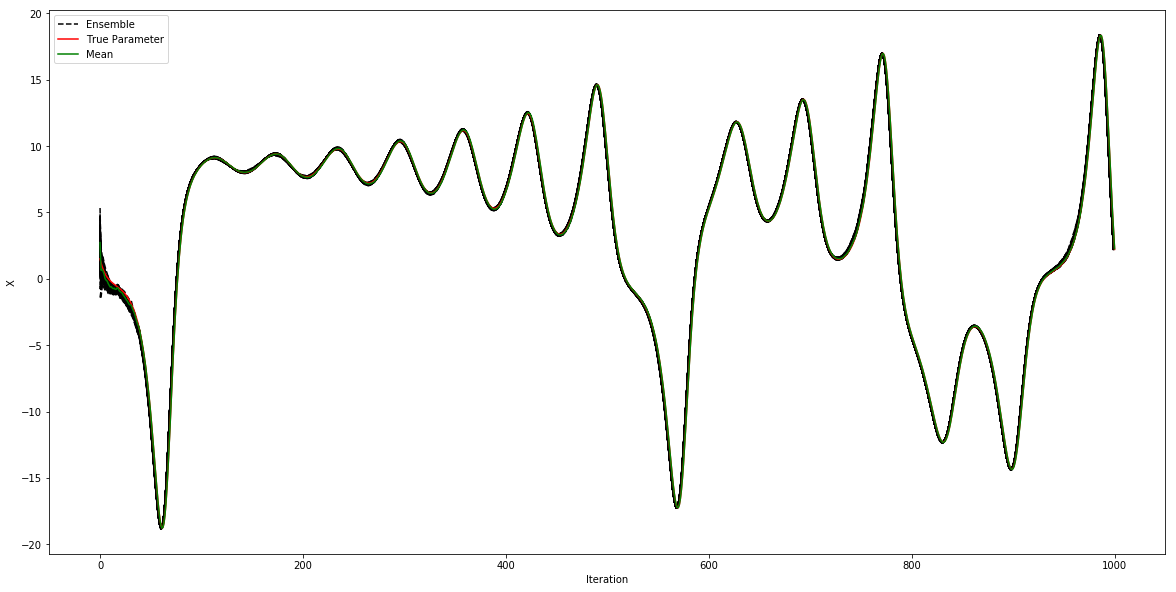

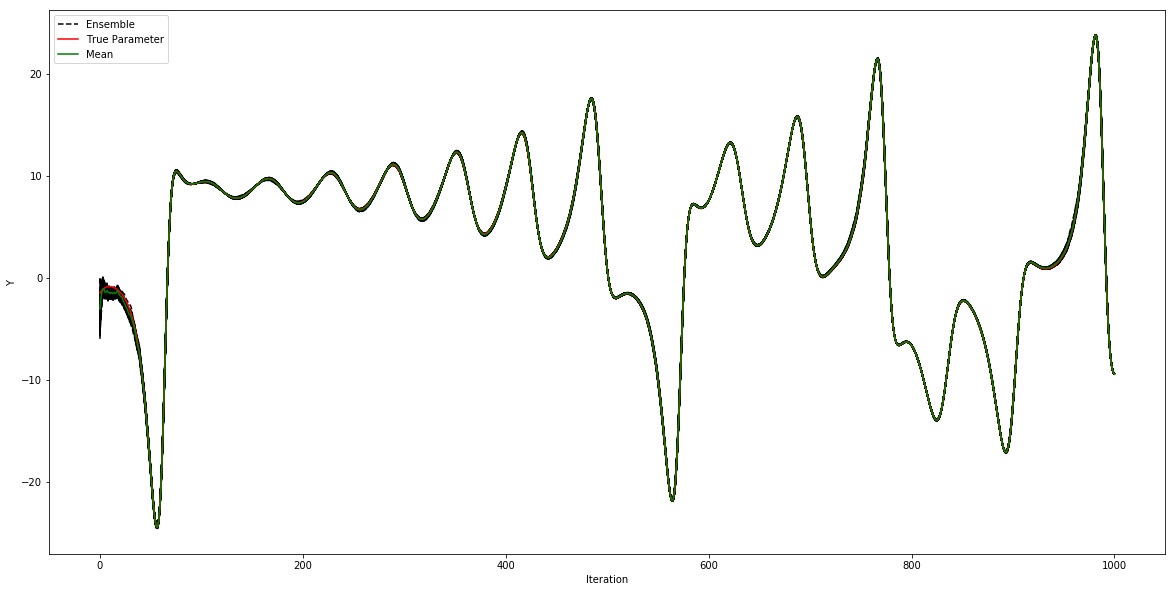

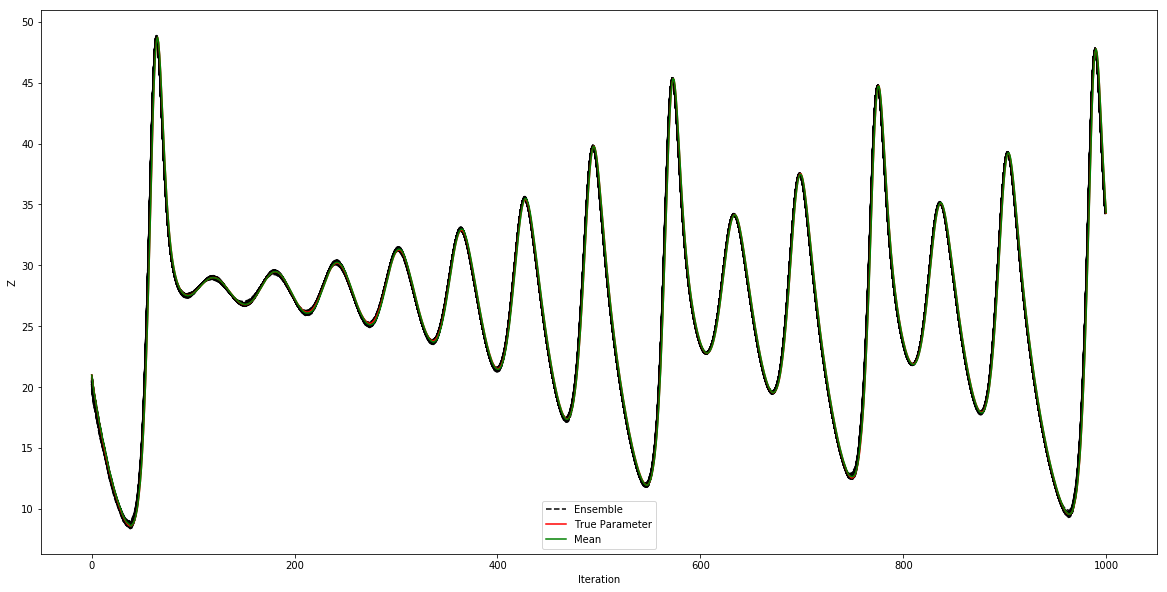

In [12]:
fig = plt.figure(figsize=(20,10))
for variable in range(Xf_enkf.shape[1]):

    X=Xf_enkf[0,variable,:]
    plt.plot(X,'k--')
    if variable==Xf_enkf.shape[1]-1:
        plt.plot(X,'k--',label='Ensemble')
plt.plot(X_true[0,:],'r-',label='True Parameter')
plt.plot(Xa_enkf_mean[0,:],'g-',label='Mean')
plt.xlabel('Iteration')
plt.ylabel('X')
plt.legend()
plt.savefig('X_EnKF_estimation.png')
plt.show()

fig_1 = plt.figure(figsize=(20,10))
for variable in range(Xa_enkf.shape[1]):
    Y=Xa_enkf[1,variable,:]
    plt.plot(Y,'k--')
    if variable==Xa_enkf.shape[1]-1:
        plt.plot(Y,'k--',label='Ensemble')
plt.plot(X_true[1,:],'r-',label='True Parameter')
plt.plot(Xa_enkf_mean[1,:],'g-',label='Mean')
plt.xlabel('Iteration')
plt.ylabel('Y')
plt.legend()
plt.savefig('Y_EnKF_estimation.png')
plt.show()

fig_2 = plt.figure(figsize=(20,10))
for variable in range(Xf_enkf.shape[1]):
    
    Z=Xf_enkf[2,variable,:]
    plt.plot(Z,'k--')
    if variable==Xa_enkf.shape[1]-1:
        plt.plot(Z,'k--',label='Ensemble')
plt.plot(X_true[2,:],'r-',label='True Parameter')
plt.plot(Xa_enkf_mean[2,:],'g-',label='Mean')
plt.xlabel('Iteration')
plt.ylabel('Z')
plt.legend()
plt.savefig('Z_EnKF_estimation.png')
plt.show()

In [13]:
print('RMSE of X '+str(RMSE(X_true[0,:] - Xa_enkf_mean[0,:])))
print('RMSE of Y '+str(RMSE(X_true[1,:] - Xa_enkf_mean[1,:])))
print('RMSE of Z '+str(RMSE(X_true[2,:] - Xa_enkf_mean[2,:])))

RMSE of X 0.07535474458010874
RMSE of Y 0.11238920709789733
RMSE of Z 0.06330614859446944


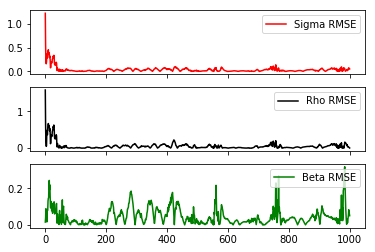

In [14]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(np.sqrt((X_true[0,:] - Xa_enkf_mean[0,:])**2), 'r-', label='Sigma RMSE')
axarr[0].legend(loc="upper right")
axarr[1].plot(np.sqrt((X_true[1,:] - Xa_enkf_mean[1,:])**2),'k-', label='Rho RMSE')
axarr[1].legend(loc="upper right")
axarr[2].plot(np.sqrt((X_true[2,:] - Xa_enkf_mean[2,:])**2), 'g-', label='Beta RMSE')
axarr[2].legend(loc="upper right")
plt.show()